In [1]:
#!pip install transformers datasets torch scikit-learn accelerate>=0.26.0

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\janinisa\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Your Dataset

In [3]:
file_path = r"Z:\BD\Novumgen\Data\Business Analysis\Backup\Nisarg\Learning\DataBase\Sentiment Analysis Dataset\Reviews.csv"
df = pd.read_csv(file_path)

In [4]:
df.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
184231,184232,B006ZC3IHY,A3SDHI39D9KLCY,C. A. Ter Haar,1,2,5,1305676800,Gloria Jean's French Vanilla K-Cups,I have tried quite a few Vanilla K-cups and th...
77301,77302,B000VK339Y,A26W0SPQ8WDSPD,Jack R. Ford,0,0,2,1272499200,Dogs don't like it,My dogs have not been too hard to please with ...
556458,556459,B0009X63VS,A245BG7SCVXDJB,"DaveTan ""davetan""",0,0,5,1341705600,Product I Received was NOT on Recall List - 2 ...,I was alarmed to hear about the recall AFTER I...
367337,367338,B0036SNKZ0,AOLEO7XBE69C5,Mary Jane Jarvis,0,0,5,1277337600,Delightful delectable iced tea.,Celestial Seasonings has hit the ball out of t...
90635,90636,B001D0MF22,A3KSAGWOFA4KJV,Rosie,0,0,4,1268179200,"Rich, dark roast coffee........",I was given a Keurig coffee brewer for Christm...


In [5]:
df['Score'].value_counts(ascending=False)

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [6]:
def label_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating >= 4:
        return 'Positive'
    else:
        return 'Neutral'

In [7]:
df['Sentiment'] = df['Score'].apply(label_sentiment)

In [8]:
df.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
237771,237772,B000EA3M4M,A2GF7MS4FRDMA5,"R. P. MD ""deliveryman""",0,0,5,1333843200,ssweet!,"fair trade, better than fair price and double ...",Positive
436753,436754,B008O3G2GG,ADEZOPMPKK146,Will,1,1,5,1319155200,Great Dog Treat,My dog LOVES Lickety Stik in the bacon flavor....,Positive
42530,42531,B0029NS90E,A1E7KO5R4VUDK1,"J. Keith ""janto2""",0,0,5,1315699200,Great Value for a great product,"The new pricing plus discount, makes this prod...",Positive
318319,318320,B000A10TV4,ASST604RB6G0E,"love dogs ""morgan""",3,3,5,1244160000,Excellent product,"Dogs love them, no mess, no gas, no choking, n...",Positive
40497,40498,B00020HHRW,AL1EKHJ4UZF8Z,smilin29,0,0,5,1328400000,It works!,I have used this product for quite some time o...,Positive


In [9]:
df['Sentiment'].value_counts()

Sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64

In [10]:
data =df[['Text','Sentiment']]

In [11]:
data.rename(columns={'Text':'review_text'},inplace=True)

C:\Users\janinisa\AppData\Local\Temp\ipykernel_14844\150988234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Text':'review_text'},inplace=True)


In [12]:
sentiment_map = {
    'Positive' : 1,
    'Negative' : 0,
    'Neutral' : 2
}

data['Sentiment'] = data['Sentiment'].map(sentiment_map).astype('int32')

C:\Users\janinisa\AppData\Local\Temp\ipykernel_14844\1218865742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment'] = data['Sentiment'].map(sentiment_map).astype('int32')


In [13]:
data.info(), data['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_text  568454 non-null  object
 1   Sentiment    568454 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 6.5+ MB


(None,
 Sentiment
 1    443777
 0     82037
 2     42640
 Name: count, dtype: int64)

## Sampling Data

In [14]:
from sklearn.utils import resample

# Keep class balance proportional
sample_size = 3000  # adjust between 1000–5000 depending on your CPU
data_sampled = data.groupby('Sentiment', group_keys=False).apply(
    lambda x: x.sample(frac=sample_size / len(data), random_state=42)
)

C:\Users\janinisa\AppData\Local\Temp\ipykernel_14844\3373112487.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sampled = data.groupby('Sentiment', group_keys=False).apply(


In [15]:
data_sampled.info(), data_sampled['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 525327 to 183351
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  3000 non-null   object
 1   Sentiment    3000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 58.6+ KB


(None,
 Sentiment
 1    2342
 0     433
 2     225
 Name: count, dtype: int64)

## Spliting Dataset

In [16]:
train_df, test_df = train_test_split(data_sampled, test_size=0.2, random_state=42)

In [17]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 465607 to 468135
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  2400 non-null   object
 1   Sentiment    2400 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 538116 to 72871
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  600 non-null    object
 1   Sentiment    600 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 11.7+ KB


(None, None)

## Converting into HuggingFace Dataset

### Que: Why we have to convert into HuggingFace Dataset format?
#### Ans: Work seamlessly with Hugging Face’s tokenizers and data collators, support tokenization and batched mapping, allow fast loading, shuffling, and filtering — even with large datasets, optimized for PyTorch and TensorFlow training.

In [18]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [19]:
train_dataset, test_dataset

(Dataset({
     features: ['review_text', 'Sentiment', '__index_level_0__'],
     num_rows: 2400
 }),
 Dataset({
     features: ['review_text', 'Sentiment', '__index_level_0__'],
     num_rows: 600
 }))

In [20]:
train_dataset['review_text'][0]

"I'm a ramyun addict and I have always loved ramyun since I was little.  It is the first thing I crave when I'm hungry and it's the only thing I can keep down when I'm hung-over. Ramyun has been and will always be my comfort food although I consider them very unhealthy. When I first spotted the Black Shin Ramyun on Amazon, I thought it was too expensive and didn't want to buy an entire box especially while I've been trying so hard to stay away from ramyun products to reduce my sodium and other toxic intakes. After many fruitless searches at nearby Asian markets to try a few packets, I ended up getting a case from Amazon after several months of hesitation; what can I say...I have to try all ramyun that I notice. Upon trying, I must say that I'm not disappointed at all and this is my new favorite ramen for the moment. The broth is thicker (from the beef bone extract powder) and has a bit of miso flavor very similar to the restaurant quality Japanese (non-instant) miso ramyun. It is defin

In [21]:
train_dataset['Sentiment'][0]

1

In [22]:
train_dataset['__index_level_0__'][0]

465607

In [23]:
data['review_text'][465607]

"I'm a ramyun addict and I have always loved ramyun since I was little.  It is the first thing I crave when I'm hungry and it's the only thing I can keep down when I'm hung-over. Ramyun has been and will always be my comfort food although I consider them very unhealthy. When I first spotted the Black Shin Ramyun on Amazon, I thought it was too expensive and didn't want to buy an entire box especially while I've been trying so hard to stay away from ramyun products to reduce my sodium and other toxic intakes. After many fruitless searches at nearby Asian markets to try a few packets, I ended up getting a case from Amazon after several months of hesitation; what can I say...I have to try all ramyun that I notice. Upon trying, I must say that I'm not disappointed at all and this is my new favorite ramen for the moment. The broth is thicker (from the beef bone extract powder) and has a bit of miso flavor very similar to the restaurant quality Japanese (non-instant) miso ramyun. It is defin

## Tokenize Text

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    tokenized = tokenizer(
        example['review_text'],
        truncation=True,
        padding = 'max_length',
        max_length=128
    )
    tokenized['labels'] = example['Sentiment']
    return tokenized

### Explanation:
#### Loads the pre-trained BERT tokenizer for 'bert-base-uncased'. “uncased” = it lowercases all text. Creates a tokenizer object you can use to turn text → token IDs.
#### example\['review_text'] → This pulls the text from your dataset — one batch of examples at a time.
#### truncation=True → If the text is longer than 128 tokens, cut it off (so model input size stays fixed).
#### padding = 'max_length' → While truncation cuts sequences that are too long, padding adds zeros to sequences that are too short to make them all the same length.
#### max_length=128 → Each sequence is exactly 128 tokens long (BERT’s max is 512, but 128 is faster and usually fine for sentiment tasks).
#### tokenized\['labels'] = example\['Sentiment'] → Adds the sentiment value (0, 1, 2) as a new field named 'labels'. Hugging Face’s Trainer automatically looks for this 'labels' key during training — so this step links your target variable to each example.

### Apply tokenization to the entire dataset

In [25]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 610.92 examples/s]


### Explanation:
#### .map() applies your function to every example in the dataset.
#### batched=True means it processes multiple rows at once (much faster than looping one by one).
#### The resulting datasets now contain numeric tensors instead of raw text.

In [26]:
train_dataset.column_names

['review_text',
 'Sentiment',
 '__index_level_0__',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'labels']

### Initially we had only 2 cols: review_text & Sentiment
### then __index_level_0__ added as we have converted database into huggingface Dataset objects
### As we applied tokenization on this we got 4 extra columns
#### 1) input_ids : Token IDs of the review text
#### 2) token_type_ids : Tell BERT which token belongs to which sentence
#### 3) attention_mask : Tells the model which tokens are real text and which tokens are padding. BERT expects input tensors of the same length (e.g., max_length=128), so shorter sentences are padded with zeros. Without attention_mask, BERT would treat padding tokens as real input, which can hurt performance.
#### 4) labels : Target sentiment label
### we keep only last 4 columns rest are unnecessary for training

In [27]:
columns_to_remove = ['review_text', 'Sentiment', '__index_level_0__']
train_dataset = train_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

In [28]:
train_dataset.column_names, test_dataset.column_names

(['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 ['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

## Load Pretrained BERT Model

In [29]:
num_labels = len(data['Sentiment'].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Explanation:
#### num_labels → This ensures the output layer of BERT matches your number of classes.
#### BertForSequenceClassification is a BERT model with an added classification head: Pretrained BERT encoder → \[CLS] token embedding → Linear layer → Output logits
#### from_pretrained('bert-base-uncased') loads the pretrained weights from BERT’s base model.

## Define Training Arguments

In [30]:
training_args = TrainingArguments(
    output_dir='./result',
    eval_strategy='steps',
    eval_steps= 100,
    save_strategy='no',  # Disable saving
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',  # log every X steps
    logging_steps=50,          # log training loss every 50 steps
    save_total_limit=0,  # Don't save any checkpoints
    no_cuda=True,  # Force CPU if GPU issues exist
)

C:\Users\janinisa\AppData\Local\miniconda3\Lib\site-packages\transformers\training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


### Explanation:
#### 1) output_dir='./result' : Where the model, tokenizer, and training logs will be saved after training. Even if you disable saving (save_strategy='no'), some temporary outputs or metrics may still be stored here.
#### 2) eval_strategy='epoch'Determines how often evaluation runs during training.'epoch' → evaluate once after each full pass through the training dataset. Other options: 'steps' (evaluate every N steps) or 'no' (never evaluate).
#### 3) eval_steps= 100 → if eval_strategy='steps' then this can b use. Steps per epoch = 3000/8 =375 As evalution is being done after every 100 step here 3-4 times evaluation will be done.
#### 5) learning_rate=2e-5 Too high → may diverge; too low → may converge slowly. 2e-5 is a standard starting point for fine-tuning BERT.
#### 6) per_device_train_batch_size=8 → Batch size per device (CPU/GPU) during training.
#### 7) per_device_eval_batch_size=8 → Batch size per device during evaluation.
#### 8) num_train_epochs=1 → Number of passes over the entire training dataset.
#### 9) weight_decay=0.01 → L2 regularization applied to model weights. Helps prevent overfitting, especially for small datasets.
#### 10) logging_dir='./logs' → Directory where TensorBoard logs are saved. You can visualize training metrics with TensorBoard.
#### 11) save_total_limit=0 → Limits the number of saved checkpoints. 0 → don’t save any, consistent with save_strategy='no'.
#### 12) no_cuda=True → Forces CPU training, even if a GPU is available.

In [31]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())

0
False


## Define Trainer

In [32]:
trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

### Explanation:
#### data_collator=DataCollatorWithPadding(tokenizer=tokenizer): In tokenize_function we use padding of 128 no matter how small the token sequences are, which lead to unnecessary padding. With Data Collator Dynamic Padding is possible. DataCollatorWithPadding is a built-in collator in Hugging Face that automatically pads sequences in a batch to the length of the longest sequence in that batch.
#### tokenizer=tokenizer : This will tell DataCollatorWithPadding which token is used for padding. Also tells Padding side: Knows whether to pad on the left or right.

## Train the Model

In [33]:
trainer.train()

Step,Training Loss,Validation Loss
100,0.460000,0.445747
200,0.432800,0.413568
300,0.385400,0.407252


TrainOutput(global_step=300, training_loss=0.46954681396484377, metrics={'train_runtime': 1588.8545, 'train_samples_per_second': 1.511, 'train_steps_per_second': 0.189, 'total_flos': 157868050636800.0, 'train_loss': 0.46954681396484377, 'epoch': 1.0})

## Predict on New Data

In [36]:
test_texts = [
    "I did absolutely love this!",
    "No Worthy the price."
]

In [37]:
inputs = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=128)
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

print(predictions)

tensor([1, 0])


#### Pedictions seem to be true, but lets evaluate this model

## Evaluation of the Model

In [38]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

In [39]:
predictions = trainer.predict(test_dataset)
pred = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

In [41]:
accuracy = accuracy_score(labels, pred)
precision, recall, f1, _ =  precision_recall_fscore_support(labels, pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8667
Precision: 0.8173
Recall: 0.8667
F1-score: 0.8409


In [43]:
print("Confusion Matrix:")
print(confusion_matrix(labels, pred))

Confusion Matrix:
[[ 81  19   2]
 [ 20 439   0]
 [ 19  20   0]]


### As Data is skewed, model can classify clearly positvie review but have difficulties in negative and neutral classification.
### You can clearly see this in confusion matrix.
### Model can not calssify actual neutral text into neutral label.
### we have to retake the sample and this time data must be balanced.

## As our dataset is inbalanced due to that it has become biased toward positive outcome

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
 10  Sentiment               568454 non-null  object
dtypes: int64(5), object(6)
memory usage: 47.7+ MB


In [10]:
df.sample()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
34206,34207,B001P3NU30,A2PDFQD34J9JRV,Amanda Peterson,0,0,5,1306454400,My dog Ellie loves these chews!,"I buy these often, I'm always satisfied. My do...",Positive


In [11]:
sentiment_map = {
    'Positive' : 1,
    'Negative' : 0,
    'Neutral' : 2
}

df['Sentiment'] = df['Sentiment'].map(sentiment_map).astype('int32')

In [12]:
df.sample()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
256470,256471,B0012N9O60,A2S8UCZ373SY53,Mark Twain,0,0,5,1344297600,Yummy. I bought Yummy from Amazon.com,It's a good frigg'n coffee flavored sucking ca...,1


In [13]:
data_balanced = df[['Text','Sentiment']]
data_balanced.sample()
data_balanced.shape

(568454, 2)

#### lets have 1500 samples for each lable

In [14]:
'''

sample_size = 1500
data_balanced = (
    data_balanced.groupby('Sentiment', group_keys=False)
    .apply(lambda x: x.sample(sample_size, random_state=42))
    .reset_index(drop=True)
)

'''

"\n\nsample_size = 1500\ndata_balanced = (\n    data_balanced.groupby('Sentiment', group_keys=False)\n    .apply(lambda x: x.sample(sample_size, random_state=42))\n    .reset_index(drop=True)\n)\n\n"

#### As Neutral is not getting converged we are increaseing its sample size so model can learn more

In [15]:
sample_sizes = {1: 1500}  # custom sample size for sentiment 2
default_size = 2500       # default for other sentiments

data_balanced = (
    data_balanced.groupby('Sentiment', group_keys=False)
    .apply(lambda x: x.sample(
        n=sample_sizes.get(x.name, default_size),  # use custom size if exists
        random_state=42
    ))
    .reset_index(drop=True)
)

C:\Users\janinisa\AppData\Local\Temp\ipykernel_7188\4062853297.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


In [16]:
data_balanced.info()
data_balanced['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       6500 non-null   object
 1   Sentiment  6500 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 76.3+ KB


Sentiment
0    2500
2    2500
1    1500
Name: count, dtype: int64

In [17]:
data_balanced.head(10)

,Text,Sentiment
0,"I have an absolute passion for deep, dark hot ...",0
1,"This drink is so ""super energy"" it's almost fr...",0
2,"I'm sticking with what used to be carnation, n...",0
3,Aspertame causes alot of problems including pr...,0
4,I ordered these because my local pet store sto...,0
5,"Generally speaking, I love mussels and was hop...",0
6,The price is too high compared to our local co...,0
7,I don't want to say these are awful but I won'...,0
8,My picky eater of a dog likes most of the Smok...,0
9,I was so excited to try this after the reviews...,0


In [18]:
data_balanced.tail(10)

,Text,Sentiment
6490,some of these survived shipping ok. some were...,2
6491,I started this seed kit in February. All three...,2
6492,We do many activities that include our Camelba...,2
6493,"It's hard to find birthday cakes to ship, espe...",2
6494,"Quick sale, received it right away! I was real...",2
6495,"Aroma is super, but flavor is lacking. This i...",2
6496,Putting flavor on regular water really depends...,2
6497,This item is a steal of a deal from Amazon.<br...,2
6498,My family likes Taco Bell and we like this Jal...,2
6499,the seller was fast to ship and at this time t...,2


#### Here you can see that data is ordered in classes mean 1st 1500 are Negative then Neutral and then Positive. This can lead to an order bias.
#### to avoid this we shuffle the data.

In [19]:
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
data_balanced.head(10)

,Text,Sentiment
0,So it must be good. He never lies to me. Eve...,1
1,Nothing wrong with this product. It is instant...,2
2,The worst!!! it is just plan awful bitter and ...,0
3,My cats really like this food!! I wish the com...,1
4,I ordered these thinking they were an instant ...,2
5,"It's okay, but I wouldn't buy it again. My ab...",2
6,Was really bummed to find out that these choco...,0
7,"Alright, either this thing has no scooper or m...",0
8,"These noodles are okay, but I like Sea Tangle ...",2
9,This is the best hot cocoa I have tried for th...,1


## Spliting Dataset¶

In [21]:
train_df, test_df = train_test_split(data_balanced, test_size=0.2, random_state=42)

In [22]:
train_df['Sentiment'].value_counts()

Sentiment
2    2006
0    1992
1    1202
Name: count, dtype: int64

## Converting into HuggingFace Dataset

In [23]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [24]:
train_dataset, test_dataset

(Dataset({
     features: ['Text', 'Sentiment', '__index_level_0__'],
     num_rows: 5200
 }),
 Dataset({
     features: ['Text', 'Sentiment', '__index_level_0__'],
     num_rows: 1300
 }))

## Tokenize Text

In [25]:
'''

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(example):
    tokenized = tokenizer(
        example['Text'],
        truncation=True,
        padding = 'max_length',
        max_length=128
    )
    tokenized['labels'] = example['Sentiment']
    return tokenized

'''

"\n\ntokenizer = BertTokenizer.from_pretrained('bert-base-uncased')\ndef tokenize_function(example):\n    tokenized = tokenizer(\n        example['Text'],\n        truncation=True,\n        padding = 'max_length',\n        max_length=128\n    )\n    tokenized['labels'] = example['Sentiment']\n    return tokenized\n\n"

In [24]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
def tokenize_function(example):
    tokenized = tokenizer(
        example['Text'],
        truncation=True,
        padding = 'max_length',
        max_length=128
    )
    tokenized['labels'] = example['Sentiment']
    return tokenized

## Apply tokenization to the entire dataset

In [25]:
train_dataset = train_dataset.map(tokenize_function,batched=True)
test_dataset = test_dataset.map(tokenize_function,batched=True)

Map: 100%|█████████████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 891.50 examples/s]


In [66]:
train_dataset.column_names

['Text',
 'Sentiment',
 '__index_level_0__',
 'input_ids',
 'attention_mask',
 'labels']

In [26]:
columns_to_remove = ['Text', 'Sentiment', '__index_level_0__']
train_dataset = train_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

In [27]:
train_dataset.column_names, test_dataset.column_names

(['input_ids', 'attention_mask', 'labels'],
 ['input_ids', 'attention_mask', 'labels'])

## Load Pretrained BERT Model

In [28]:
num_labels = len(data_balanced['Sentiment'].unique())
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_labels
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Training Arguments

In [29]:
training_args = TrainingArguments(
    output_dir='./result',
    eval_strategy='steps',
    eval_steps= 65,
    save_strategy='no',  # Disable saving
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',  # log every X steps
    logging_steps=50,          # log training loss every 50 steps
    save_total_limit=0,  # Don't save any checkpoints
    no_cuda=True,  # Force CPU if GPU issues exist
)

C:\Users\janinisa\AppData\Local\miniconda3\Lib\site-packages\transformers\training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


## Define Trainer

In [30]:
trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

## Train the Model

In [31]:
trainer.train()

Step,Training Loss,Validation Loss
65,1.073700,1.006561
130,1.000100,0.748564
195,0.821100,0.664403
260,0.654100,0.626626
325,0.670300,0.656258
390,0.727900,0.598755
455,0.633300,0.594482
520,0.620600,0.594242
585,0.611100,0.587427
650,0.493400,0.596219


TrainOutput(global_step=650, training_loss=0.7132328532292292, metrics={'train_runtime': 4052.7091, 'train_samples_per_second': 1.283, 'train_steps_per_second': 0.16, 'total_flos': 342047443046400.0, 'train_loss': 0.7132328532292292, 'epoch': 1.0})

## Save the Model

In [45]:
import os
my_path = r'Z:\BD\Novumgen\Data\Business Analysis\Backup\Nisarg\Learning\DataBase\Sentiment Analysis Dataset\roBERTa fine tuned Model'
save_directory = os.path.join(my_path, "roberta-sentiment-model")
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print("Fine-tuned model and tokenizer saved successfully at:", save_directory)

Fine-tuned model and tokenizer saved successfully at: Z:\BD\Novumgen\Data\Business Analysis\Backup\Nisarg\Learning\DataBase\Sentiment Analysis Dataset\roBERTa fine tuned Model\roberta-sentiment-model


## Predict on New Data

In [10]:
test_texts = ["Done product demonstration, she was not much attentive during the discussion as she was in rush. But she asked few basic questions about the product, pricing and channel of product availablity."]

In [3]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

C:\Users\janinisa\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_path = r"Z:\BD\Novumgen\Data\Business Analysis\Backup\Nisarg\Learning\DataBase\Sentiment Analysis Dataset\roBERTa fine tuned Model\roberta-sentiment-model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

In [11]:
inputs = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=128)
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

print(predictions)

tensor([2])


tensor(1)

## Evaluation of the Model

### using Accuracy, F1, Recall, Precision etc...

In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [35]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

In [36]:
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ =  precision_recall_fscore_support(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7523
Precision: 0.7542
Recall: 0.7523
F1-score: 0.7526


In [37]:
print("Confusion Matrix:")
print(confusion_matrix(labels, preds))

Confusion Matrix:
[[403  10  95]
 [ 15 232  51]
 [121  30 343]]


#### Model sometimes got confusion Neutral with emotional labels like +ve or -ve

### ROC/AUC Curve

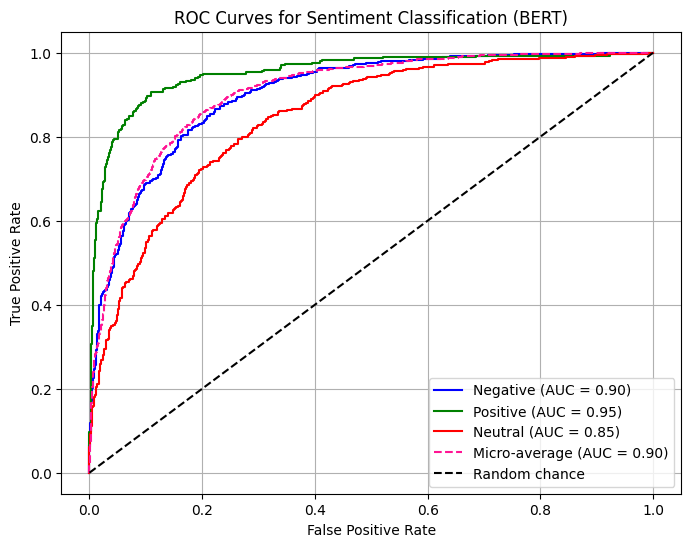

Macro-average AUC: 0.8998


In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get probabilities from model
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_score = predictions.predictions  # raw logits

# Binarize labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Negative, Positive, Neutral

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
labels = ['Negative', 'Positive', 'Neutral']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--',
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

plt.title("ROC Curves for Sentiment Classification (BERT)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Macro-average AUC
macro_auc = np.mean(list(roc_auc.values())[:-1])  # exclude micro
print(f"Macro-average AUC: {macro_auc:.4f}")

## Explaination of Model using LIME & SHAP

In [26]:
pip install lime transformers torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from lime.lime_text import LimeTextExplainer
import numpy as np

C:\Users\janinisa\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = r"Z:\BD\Novumgen\Data\Business Analysis\Backup\Nisarg\Learning\DataBase\Sentiment Analysis Dataset\roBERTa fine tuned Model\roberta-sentiment-model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.eval()  # set model to evaluation mode

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Define a Prediction Function for LIME

In [3]:
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True,
                       padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.detach().cpu().numpy()

### Initialize the LIME Explainer

In [4]:
class_names = ["Negative", "Positive", "Neutral"]  # adjust order if different in your data
explainer = LimeTextExplainer(class_names=class_names)

### Text to Explain

In [5]:
sample_text = "The movie was okay, but a bit too long and boring in parts."

### Generate the Explanation

In [6]:
exp = explainer.explain_instance(
    sample_text, 
    predict_proba, 
    num_features=10,  # show top 10 important tokens
    labels=[0, 1, 2]  # Negative, Neutral, Positive
)

In [2]:
exp.show_in_notebook(text=sample_text)

NameError: name 'exp' is not defined

In [1]:
from IPython.core.display import display, HTML
display(HTML("<b>IPython works!</b>"))

ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\janinisa\AppData\Local\miniconda3\Lib\site-packages\IPython\core\display.py)